### Цель проекта

Разработать сервис, определяющий, правильно ли сориентирована медицинская справка, загруженная пользователем в сервис для доноров DonorSearch.

Заказчик - DonorSearch -  занимается развитием донорства в стране. Для этого есть платформа DonorSearch.org - где для доноров доступны бонусная программа, игрофикация пути донора и многое другое. Важной является проверка честности доноров и корректности внесенных донаций. Подтверждение производится по справке установленной формы (№405), такую справку донор получает в центре крови.  Далее загружает как картинку или pdf в личный кабинет. 

#### Импорт библиотек

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import warnings
warnings.filterwarnings("ignore")
import os #
import zipfile
import pytesseract
import torch #
import torchvision
from torchvision import datasets, transforms, models #
from torch.utils.data import Dataset,DataLoader, ConcatDataset #
from torchvision import datasets, transforms
from torchvision.transforms import v2 as T
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn #
import torch.nn.functional as F
import torch.optim as optim #
from torch.optim import lr_scheduler
from time import time
from tqdm import tqdm
from PIL import Image #
from skimage.io import imread
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
import cv2
import matplotlib.pyplot as plt #
import seaborn as sns #
import random
import shutil
from sklearn.preprocessing import label_binarize
from torchvision.models import resnet50, ResNet50_Weights, densenet121, DenseNet121_Weights,resnet18, ResNet18_Weights, vgg19
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay #

/kaggle/input/labels-image/labels_image.csv
/kaggle/input/more-images/more_images/405___b6c1b16eaa1240a3a5fdb9d272133404_rotated_90.png
/kaggle/input/more-images/more_images/405___photo_2023-03-17_16-43-55_original.png
/kaggle/input/more-images/more_images/405___701b3c25428b4f6c8d71396037202683_rotated_90.png
/kaggle/input/more-images/more_images/405___b7a58da969de42ecb64c589d3ecd7642_original.png
/kaggle/input/more-images/more_images/405___83a46dc4d8554fecae624a5422028422_rotated_180.png
/kaggle/input/more-images/more_images/405___d810c46007b741759c70f34a857445eb_rotated_270.png
/kaggle/input/more-images/more_images/405___82094d1fddd946c3a7fdeff1f22b06fe_rotated_180.png
/kaggle/input/more-images/more_images/405___87bdaaa7ba5247c1969398f16a341917_rotated_90.png
/kaggle/input/more-images/more_images/405___049481224374486ead31511817c052f3_rotated_180.png
/kaggle/input/more-images/more_images/405___f72dc98db3df421f904e571318ce94f8_rotated_270.png
/kaggle/input/more-images/more_images/405_

#### Загрузка данных

In [2]:
# Загрузка данных из CSV
df = pd.read_csv('/kaggle/input/labels-image/labels_image.csv')  # Замените на путь к вашему файлу

# Предположим, что CSV имеет колонки 'image_path' и 'category'
# Создаем основную папку для категорий
base_dir = 'images_category'
os.makedirs(base_dir, exist_ok=True)

# Получаем уникальные категории
categories = df['category'].unique()

# Создаем папки для каждой категории
for category in categories:
    category_path = os.path.join(base_dir, category)
    os.makedirs(category_path, exist_ok=True)

# Перемещаем изображения в соответствующие папки
for index, row in df.iterrows():
    image_path = row['label']
    category = row['category']
    
    # Проверьте, существует ли изображение
    if os.path.isfile(image_path):
        # Перемещаем изображение в соответствующую папку
        shutil.copy(image_path, os.path.join(base_dir, category, os.path.basename(image_path)))
    else:
        print(f'Image not found: {image_path}')

In [3]:
# Создаем папку
output_dir = '/kaggle/working/result'
os.makedirs(output_dir, exist_ok=True)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
# Параметры
DATA_DIR = '/kaggle/working/images_category'  # Папка с изображениями
OUT_DIR = '/kaggle/working/result'
FOLDERS = ['original', '90', '180', '270']
CLASSES = {'original': 0, 
           '90': 1, 
           '180': 2,
           '270': 3    
}

In [6]:
BATCH_SIZE = 16
IMG_SIZE = 224
GENERATOR = torch.Generator().manual_seed(1001)

#### Трансформации

In [7]:
# Трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


#### Датасеты и выборки

In [8]:
class Page(torch.utils.data.Dataset):
    def __init__(self, root, label, transform):
        self.root = root
        self.label = label
        self.transforms = transform
        self.imgs = os.listdir(os.path.join(self.root, self.label))

    def __getitem__(self, idx):
        # load images and labels
        img_path = os.path.join(self.root, self.label, self.imgs[idx])
        img = Image.open(img_path)
        target = CLASSES[self.label]

        return self.transforms(img), torch.tensor(target), self.label

    def __len__(self):
        return len(self.imgs)

In [9]:
data_1 = Page(DATA_DIR, FOLDERS[0], transform)
data_2 = Page(DATA_DIR, FOLDERS[1], transform)
data_3 = Page(DATA_DIR, FOLDERS[2], transform)
data_4 = Page(DATA_DIR, FOLDERS[3], transform)
print(f'Размер категории: \n {FOLDERS[0]} - {len(data_1)} \n {FOLDERS[1]} - {len(data_2)} \n {FOLDERS[2]} - {len(data_3)} \n {FOLDERS[3]} - {len(data_4)} \n')
data_page = ConcatDataset([data_1, data_2, data_3, data_4])
train, valid, test = torch.utils.data.random_split(data_page, [.6, .2, .2], generator=GENERATOR)
print(f'Размер выборок: \nтренировочная - {len(train)} \nвалидационная - {len(valid)} \nтестовая - {len(test)}')

Размер категории: 
 original - 48 
 90 - 48 
 180 - 48 
 270 - 48 

Размер выборок: 
тренировочная - 116 
валидационная - 38 
тестовая - 38


In [10]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [11]:
batch = next(iter(train_dataloader))

#### Обзор

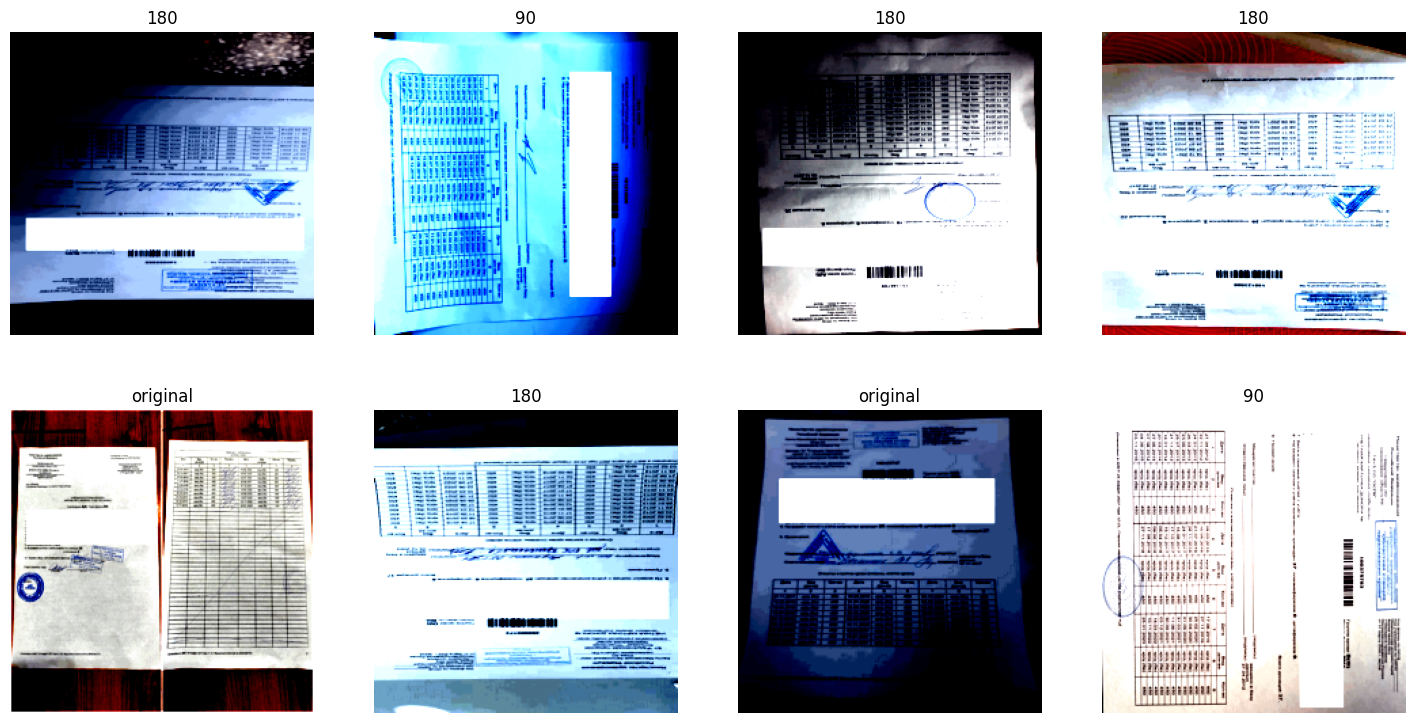

In [12]:
look = next(iter(train_dataloader))
plt.figure(figsize=(18, 9))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(look[0][i].permute(1,2,0))
    plt.title(look[2
                  ][i])
plt.show();

#### Функции обучения, оценки и визуализации

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels, _ in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels, _ in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [15]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels, _ in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.eval()
            outputs = model(inputs)
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += inputs.size(0)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc

In [16]:
def vizualize(h, model):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(model)
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title(model)
    plt.show()

In [17]:
def train(train, val, model, epochs, rate, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=rate)
        sch = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train, criterion, opt, sch)

            val_loss, val_acc = eval_epoch(model, val, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

#### Предобученные модели

##### ResNet50

In [18]:
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)

# Set requires_grad = False for all parameters
for param in resnet.parameters():
    param.requires_grad = False

# Re-enable requires_grad for the last 3 layers
layers = list(resnet.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 2048
out_features = 4
resnet.fc = nn.Linear(in_features, out_features)
resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 54.5MB/s]


In [19]:
out = resnet(torch.rand(64, 3, 224, 224).to(device))

In [20]:
out[0]

tensor([ 0.2037, -0.0541,  0.0742, -0.0815], grad_fn=<SelectBackward0>)

##### Mobilenet V2

In [21]:
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                  nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=4, bias=True))
mobilenet = mobilenet.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 103MB/s] 


##### DenseNet121

In [22]:
weights = DenseNet121_Weights.DEFAULT
dnet = densenet121(weights=weights)

in_features = 1024
out_features = 4
dnet.classifier = nn.Linear(in_features, out_features)
dnet = dnet.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 127MB/s] 


##### VGG19

In [23]:
vgg = models.vgg19(pretrained=True)
for param in vgg.parameters():
    param.requires_grad = False
    
in_features = 4096
out_features = 4    
vgg.classifier[6] = nn.Linear(in_features, out_features)
vgg = vgg.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 175MB/s] 


#### Обучение

In [24]:
crit = nn.CrossEntropyLoss()
lr = 0.01

In [25]:
history = train(train_dataloader, valid_dataloader, model=resnet, epochs=5, rate=lr, criterion=crit)

epoch:  20%|██        | 1/5 [00:38<02:34, 38.56s/it]


Epoch 001 train_loss: 1.8011     val_loss 5409722.4211 train_acc 0.3707 val_acc 0.2895


epoch:  40%|████      | 2/5 [01:15<01:52, 37.43s/it]


Epoch 002 train_loss: 1.3988     val_loss 630.6602 train_acc 0.4655 val_acc 0.1579


epoch:  60%|██████    | 3/5 [01:52<01:14, 37.37s/it]


Epoch 003 train_loss: 1.0238     val_loss 650.8928 train_acc 0.5776 val_acc 0.1579


epoch:  80%|████████  | 4/5 [02:31<00:37, 37.84s/it]


Epoch 004 train_loss: 0.9761     val_loss 21.3396 train_acc 0.7328 val_acc 0.1842


epoch: 100%|██████████| 5/5 [03:07<00:00, 37.55s/it]


Epoch 005 train_loss: 0.6596     val_loss 8.6766 train_acc 0.8621 val_acc 0.3947


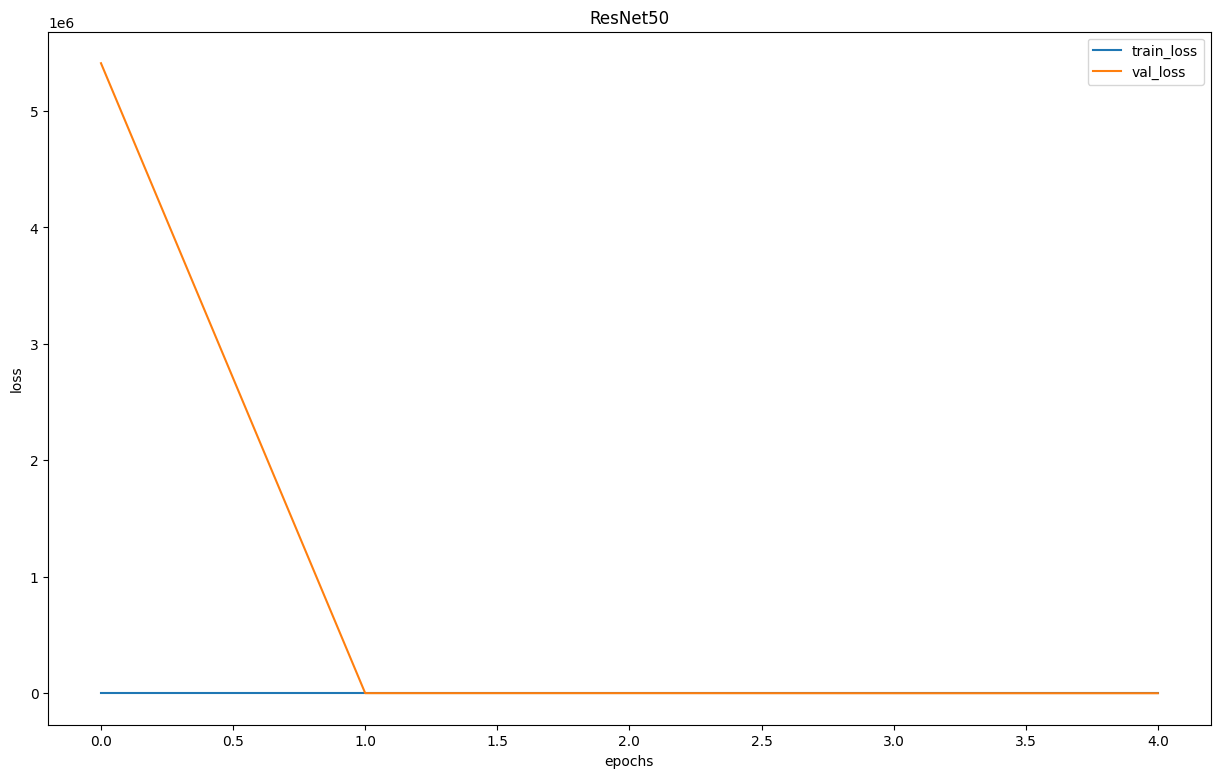

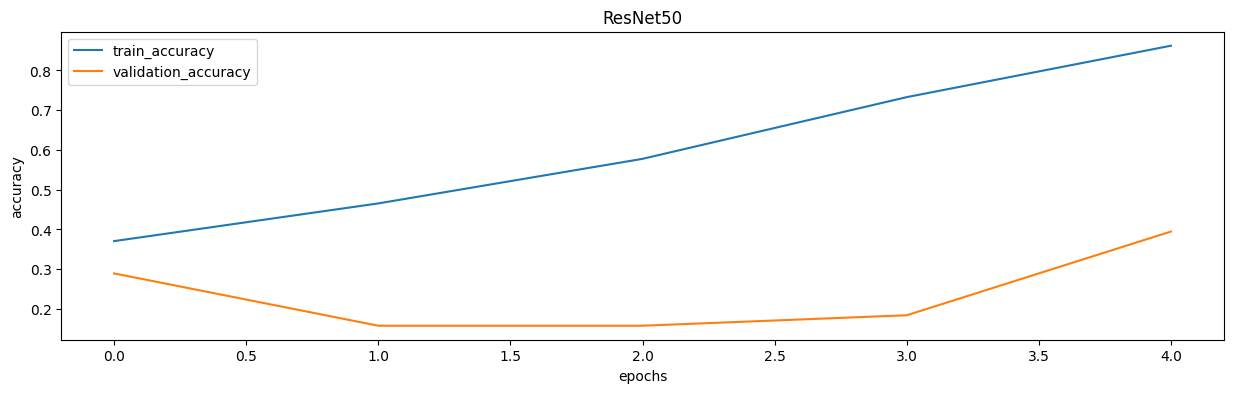

In [26]:
vizualize(history, 'ResNet50')

In [27]:
history_1 = train(train_dataloader, valid_dataloader, model=mobilenet, epochs=5, rate=lr, criterion=crit)

epoch:  20%|██        | 1/5 [00:16<01:06, 16.71s/it]


Epoch 001 train_loss: 2.7339     val_loss 4.0880 train_acc 0.3448 val_acc 0.2368


epoch:  40%|████      | 2/5 [00:34<00:51, 17.09s/it]


Epoch 002 train_loss: 1.2658     val_loss 21.9817 train_acc 0.5345 val_acc 0.3158


epoch:  60%|██████    | 3/5 [00:50<00:33, 16.96s/it]


Epoch 003 train_loss: 1.5977     val_loss 11.9528 train_acc 0.4138 val_acc 0.3684


epoch:  80%|████████  | 4/5 [01:07<00:16, 16.88s/it]


Epoch 004 train_loss: 1.7088     val_loss 6.9645 train_acc 0.3276 val_acc 0.1316


epoch: 100%|██████████| 5/5 [01:24<00:00, 16.92s/it]


Epoch 005 train_loss: 1.2395     val_loss 3.2951 train_acc 0.5086 val_acc 0.2368


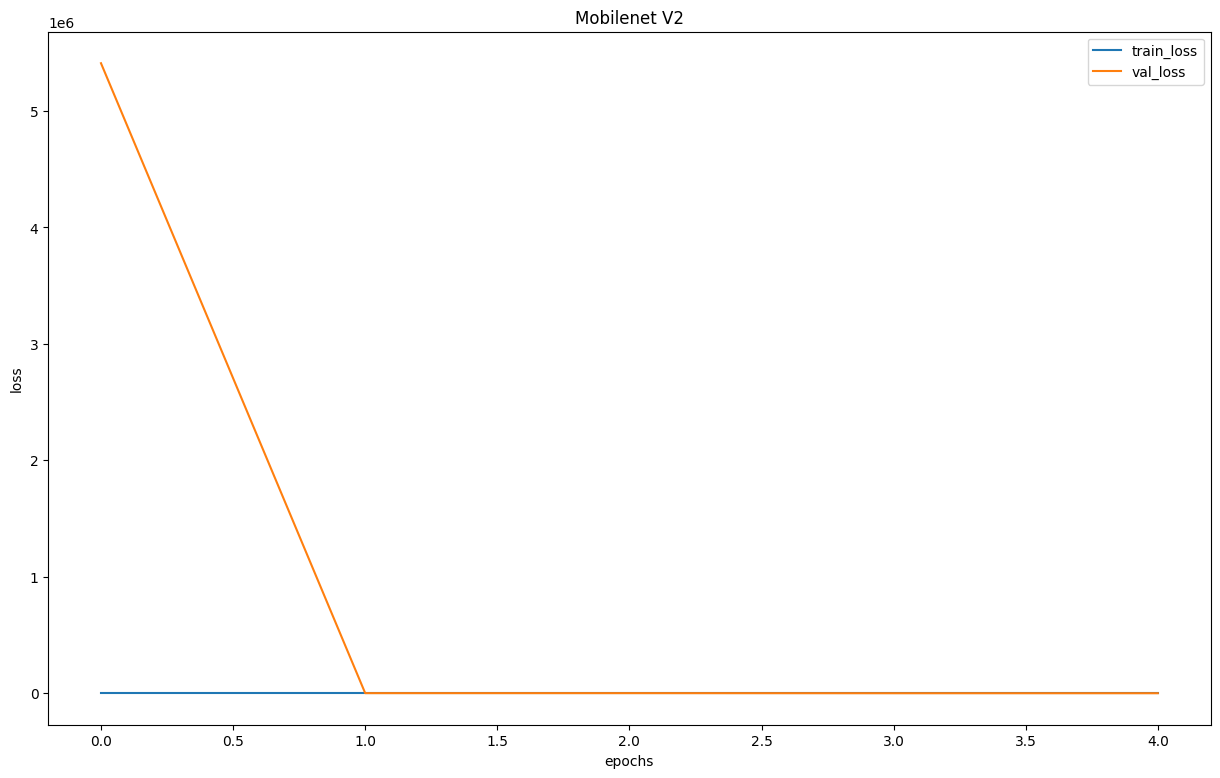

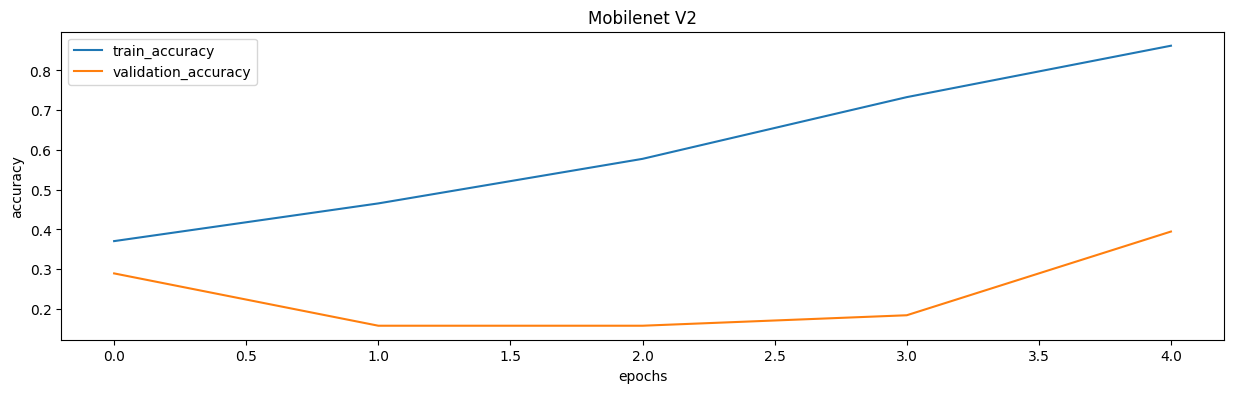

In [28]:
vizualize(history_1, 'Mobilenet V2')

In [29]:
history_2 = train(train_dataloader, valid_dataloader, model=dnet, epochs=5, rate=lr, criterion=crit)

epoch:  20%|██        | 1/5 [00:42<02:51, 42.86s/it]


Epoch 001 train_loss: 2.6693     val_loss 40288448772419.3672 train_acc 0.2241 val_acc 0.2895


epoch:  40%|████      | 2/5 [01:23<02:05, 41.71s/it]


Epoch 002 train_loss: 2.5835     val_loss 11040239104.0000 train_acc 0.2241 val_acc 0.2368


epoch:  60%|██████    | 3/5 [02:04<01:22, 41.34s/it]


Epoch 003 train_loss: 1.7913     val_loss 930921.9474 train_acc 0.3276 val_acc 0.1579


epoch:  80%|████████  | 4/5 [02:46<00:41, 41.67s/it]


Epoch 004 train_loss: 1.3623     val_loss 2227.0401 train_acc 0.4138 val_acc 0.2895


epoch: 100%|██████████| 5/5 [03:30<00:00, 42.10s/it]


Epoch 005 train_loss: 1.1675     val_loss 186.8404 train_acc 0.4914 val_acc 0.1579


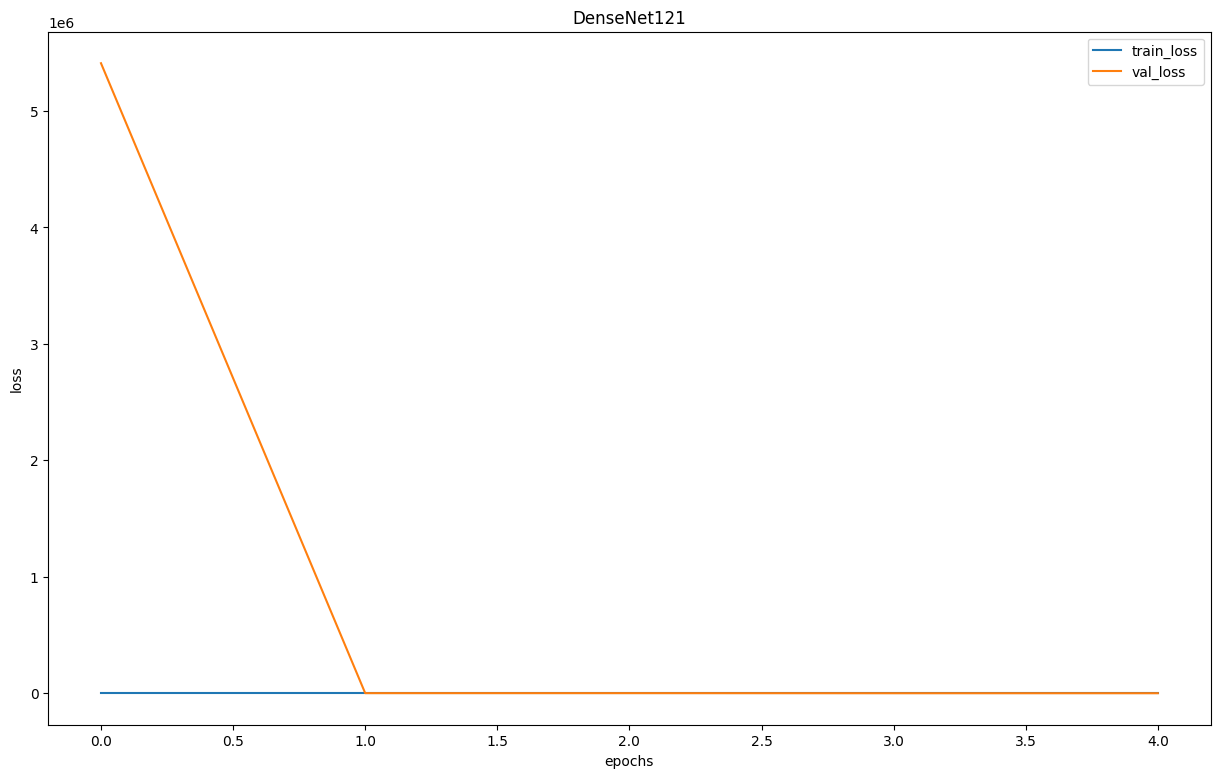

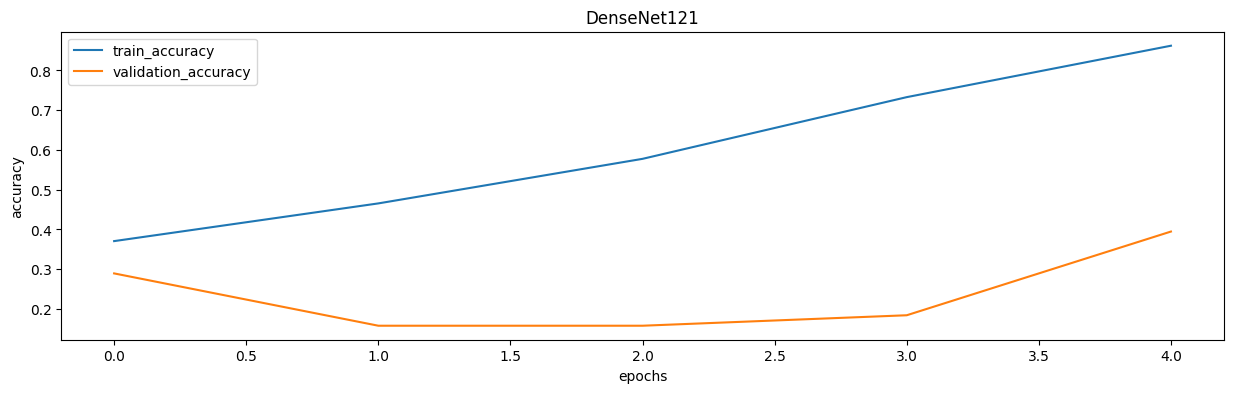

In [30]:
vizualize(history_2, 'DenseNet121')

In [31]:
history_3 = train(train_dataloader, valid_dataloader, model=vgg, epochs=5, rate=lr, criterion=crit)

epoch:  20%|██        | 1/5 [00:59<03:59, 59.90s/it]


Epoch 001 train_loss: 1.3753     val_loss 1.7889 train_acc 0.5086 val_acc 0.6316


epoch:  40%|████      | 2/5 [01:59<02:59, 59.78s/it]


Epoch 002 train_loss: 1.0299     val_loss 2.5815 train_acc 0.7500 val_acc 0.6053


epoch:  60%|██████    | 3/5 [02:59<01:59, 59.61s/it]


Epoch 003 train_loss: 1.1081     val_loss 2.3725 train_acc 0.7672 val_acc 0.5789


epoch:  80%|████████  | 4/5 [03:58<00:59, 59.50s/it]


Epoch 004 train_loss: 0.9306     val_loss 2.5780 train_acc 0.7586 val_acc 0.6053


epoch: 100%|██████████| 5/5 [04:58<00:00, 59.78s/it]


Epoch 005 train_loss: 0.9262     val_loss 2.5551 train_acc 0.7845 val_acc 0.6579


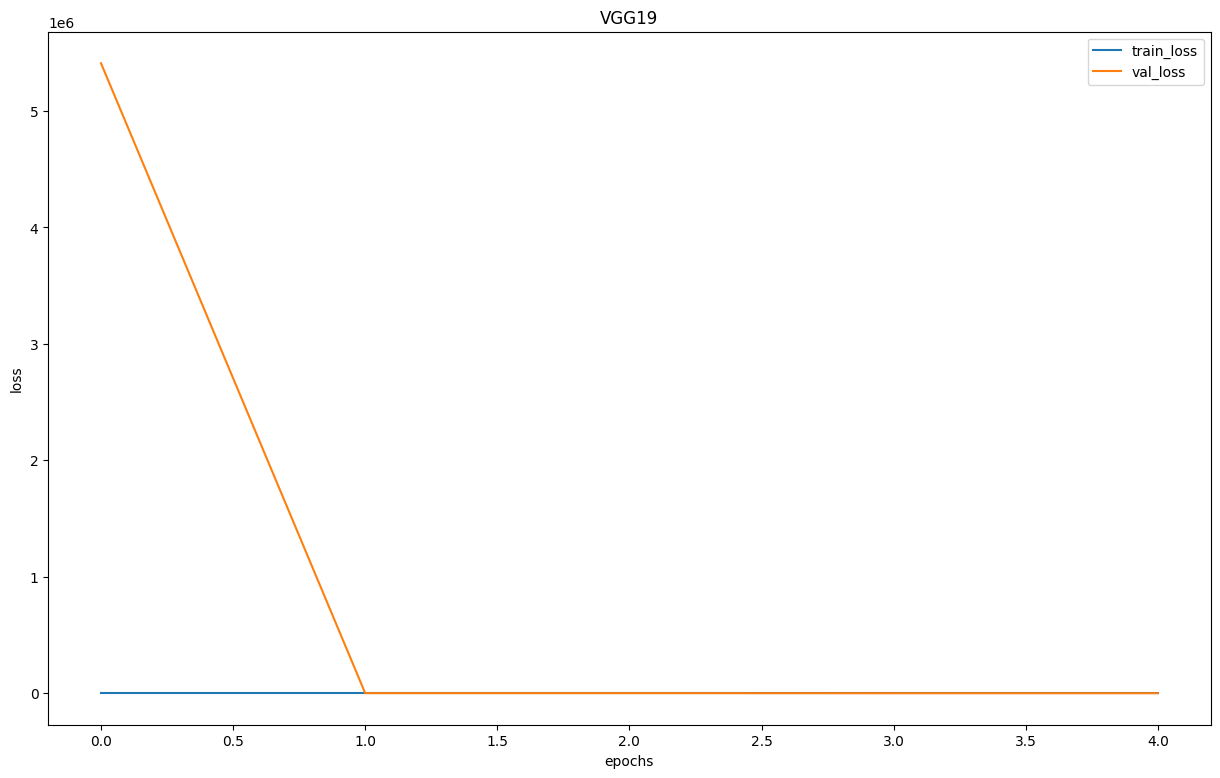

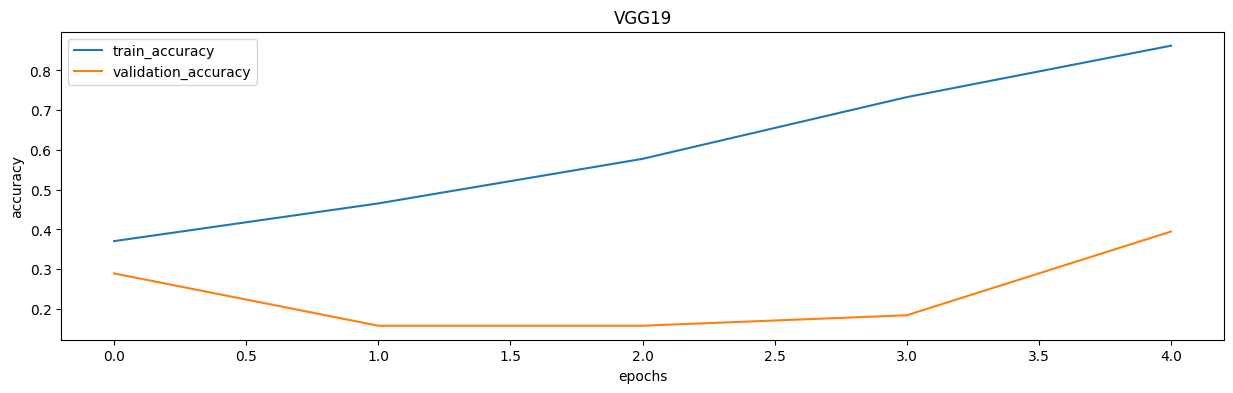

In [32]:
vizualize(history_3, 'VGG19')

#### Тестирование

In [33]:
result_1 = predict(resnet, test_dataloader)
result_2 = predict(mobilenet, test_dataloader)
result_3 = predict(dnet, test_dataloader)
result_4 = predict(vgg, test_dataloader)

In [34]:
print(f'Accuracy на тестовой выборке Resnet50 - {result_1[3]:.2}')
print(f'Accuracy на тестовой выборке Mobilenet V2 - {result_2[3]:.2}')
print(f'Accuracy на тестовой выборке DenseNet121 - {result_3[3]:.2}')
print(f'Accuracy на тестовой выборке VGG19 - {result_4[3]:.2}')

Accuracy на тестовой выборке Resnet50 - 0.37
Accuracy на тестовой выборке Mobilenet V2 - 0.26
Accuracy на тестовой выборке DenseNet121 - 0.42
Accuracy на тестовой выборке VGG19 - 0.63


### Вывод

Были протестированы еще варианты:
- batch_size 32, 64 и 128
- эпохи 15
- скорость обучения 1e-3

Результат оказался хуже, чем у лучшей модели.